In [92]:
using Cxx
using PyCall
using PyPlot

@pyimport imageio
@pyimport skimage.filters as filters
@pyimport skimage.morphology as morphology
disk = morphology.disk;

In [125]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

In [47]:
# video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/ch02_20180330092923.mp4"
video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

"/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

In [142]:
reader = imageio.get_reader(video_file);
#writer = imageio.get_writer("~/tmp/out.mp4", fps=reader[:get_meta_data]()["fps"]);

# frames = [T.preprocess_frame(reader[:get_data](i)) for i in 900:1400];
@time background = T.init_background(frames; max_iters=3);

134.522975 seconds (982.44 k allocations: 57.402 GiB, 3.19% gc time)


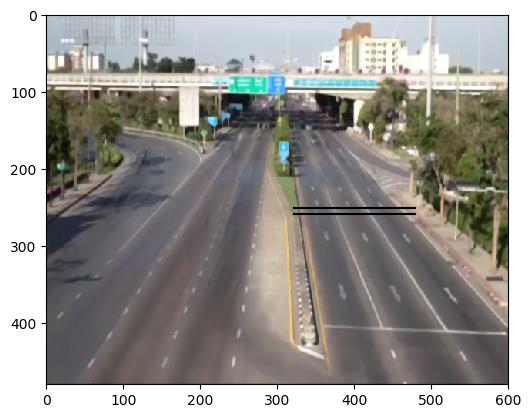

In [130]:
# slit_x = 285;
# slit_y = 200;
# slit_width = 80;
slit_x = 320;
slit_y = 250;
slit_width = 160;

block_width = 10;
block_height = 8;

imshow(background)
PyPlot.hlines(slit_y, xmin=slit_x, xmax=slit_x + slit_width)
PyPlot.hlines(slit_y + block_height, xmin=slit_x, xmax=slit_x + slit_width);

In [131]:
threshold = 0.05

0.05

In [178]:
include("src/StMrf.jl")
import StMrf
SM = StMrf;

blocks = Array{SM.Block, 2}(floor(Int, size(background, 1) / block_height) - 1, floor(Int, size(background, 2) / block_width) - 1)
for row_id in 1:size(blocks, 1)
    const row_start = row_id * block_height;
    for col_id in 1:size(blocks, 2)
        const col_start = col_id * block_width;
        blocks[row_id, col_id] = SM.Block(col_start, row_start, block_width, block_height);
    end
end

slit_coords = [SM.get_block_coords(slit_x + i * block_width, slit_y, block_width, block_height) for i in 1:floor(Int, slit_width / block_width)]
slit_line = [blocks[c...] for c in slit_coords];

new_object_id = 1;
f_id = 370;

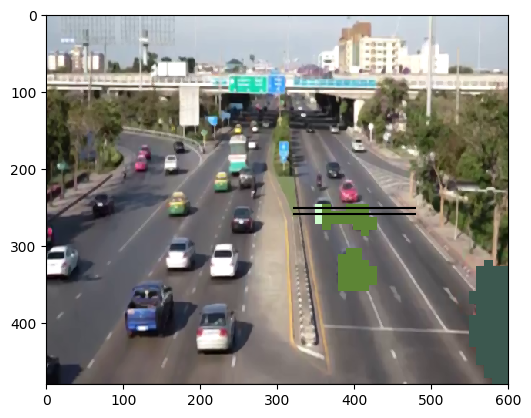

In [181]:
frame = frames[f_id];

for i in 1:66
    if f_id >= size(frames, 1)
        break
    end
    
    frame = frames[f_id];
    last_id = SM.update_slit_objects!(blocks, slit_coords, frame, background, new_object_id; threshold=threshold);
    new_object_id = max(new_object_id, last_id)
    
    global old_frame = frame;
    frame = frames[f_id + 1];

    obj_ids_map = map(b -> b.object_id, blocks);

    global object_ids = sort(unique(obj_ids_map));
    object_ids = object_ids[object_ids .> 0]
    group_coords = [collect(zip(findn(obj_ids_map .== id)...)) for id in object_ids]
    global motion_vecs = [SM.find_motion_vector(blocks, frame, old_frame, gc) for gc in group_coords]
    motion_vecs_rounded = [SM.round_motion_vector(mv, block_width, block_height) for mv in motion_vecs]
    
    if size(motion_vecs, 1) == 0
        f_id += 1
        continue
    end

    global prev_pixel_map = SM.blocks_to_object_map(blocks);
    global new_map = SM.update_object_ids(blocks, obj_ids_map, motion_vecs_rounded, group_coords, frame, background; 
                                   threshold=threshold);
    new_map[map(x -> x.end_y, blocks) .< slit_y] = Set();

    for (b, ids) in zip(blocks, new_map)
        if length(ids) == 0
            b.object_id = 0
            continue
        end
        b.object_id = collect(ids)[1]
    end

    f_id += 1
end

plot_frame = deepcopy(frame);
for b in blocks
    if b.object_id == 0
        continue
    end

    srand(b.object_id)

    plot_frame[b.y_inds(), b.x_inds(),1] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),2] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),3] .= rand()
end

T.plot_frame(plot_frame, slit_x, slit_y, slit_width, block_height);

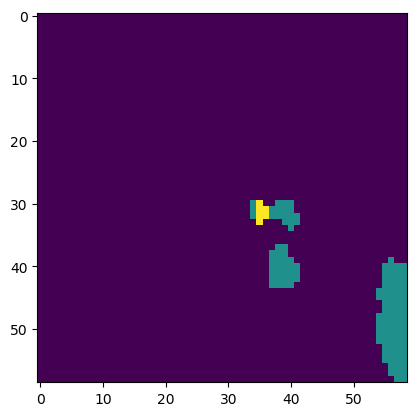

PyObject <matplotlib.image.AxesImage object at 0x7fc18c5d6b00>

In [182]:
imshow(map(length, new_map))

$U_N(N_{y_k})$: Pott's J = -$\alpha$;  
$M_{xy_k}$: number of overlapping pixel labels  
$D_{xy_k}$: image difference between a block in the previous frame and displaced block in the current frame;  

In [183]:
group_coords2 = [collect(zip(findn(map(v -> lab in v, new_map))...)) for lab in object_ids];

In [308]:
using GCoptimization

In [309]:
include("src/GcWrappers.jl")
import GcWrappers
GW = GcWrappers;

In [323]:
include("src/StMrf.jl")
import StMrf
SM = StMrf;

In [326]:
unary_penalties = SM.unary_penalties(blocks, object_ids, motion_vecs, group_coords2, prev_pixel_map, frame, old_frame);

In [327]:
gco = GW.gc_optimization_8_grid_graph(size(blocks, 1), size(blocks, 2), size(unary_penalties, 2));

GW.set_data_cost(gco, -unary_penalties)
gco_setsmoothcost(gco, GW.smooth_cost_matrix(size(unary_penalties, 2), 1))

In [328]:
gco_expansion(gco)
labels = gco_getlabeling(gco);

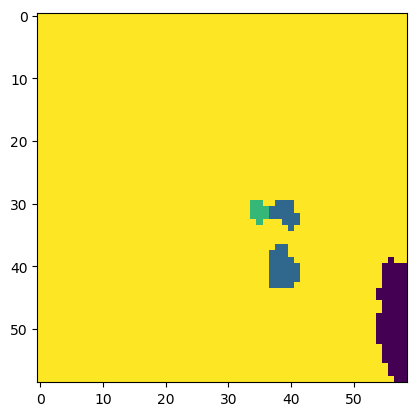

PyObject <matplotlib.image.AxesImage object at 0x7fc1e82582e8>

In [329]:
imshow(reshape(labels, size(blocks))')